
# Seph's ModelV5 Development

This notebook demonstrates the development of a custom neural network using TensorFlow and Keras, focusing on good coding practices and clear documentation.

### Library Imports
All necessary libraries are imported here for better organization.


In [39]:
%%capture
!pip install keras

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from joblib import dump

## Synthetic Sensor data

-------------------------

In [41]:
df = pd.read_csv('/content/synthetic_datasetV2.csv')
df.head(10)

,timestamp,text_data,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_125_roll_avg,sensor_125_exp_mov_avg,sensor_126_diff,sensor_126_roll_avg,sensor_126_exp_mov_avg,sensor_127_diff,sensor_127_roll_avg,sensor_127_exp_mov_avg,sensor_mean,sensor_std
0,2024-02-05 13:25:33,alpha theta zeta eta kappa,-0.444571,-0.955176,-0.999921,1.029595,-0.769716,-0.363025,0.876331,-0.298035,...,0.231707,0.141234,0.079291,1.214981,1.204485,0.740472,-1.051176,-0.803259,-0.029839,0.700979
1,2024-02-05 13:31:06,beta delta iota iota kappa,-0.560097,0.294191,-1.085475,0.922052,-0.762680,-0.560038,-0.139521,-0.297691,...,0.227828,0.163645,0.039699,0.063185,0.062123,-0.699842,0.549459,0.112421,-0.091290,0.669824
2,2024-02-05 13:29:28,eta zeta iota epsilon theta,0.815060,-0.949000,0.977785,0.933102,0.364861,-0.546613,-0.843125,-1.004237,...,-0.429786,-0.324708,0.081270,-0.586431,-0.573234,0.600389,-0.119077,0.248417,-0.044485,0.699705
3,2024-02-05 13:26:58,eta alpha gamma beta eta,1.080779,0.658332,-0.769206,0.116492,-0.249626,0.150764,0.654920,0.542819,...,-0.313310,-0.352372,-0.032744,1.425647,1.399083,0.404078,0.425698,0.639995,0.087464,0.676095
4,2024-02-05 13:23:31,eta alpha gamma beta beta,0.530007,-0.968407,-0.857061,-0.925658,-0.676481,0.446670,-0.932996,-0.927024,...,0.680819,0.702380,0.019823,0.029027,0.023561,-0.517009,1.012332,0.774067,0.108283,0.709851
5,2024-02-05 13:25:04,epsilon kappa gamma gamma delta,0.436654,-0.534909,0.761558,-0.672712,0.975552,-0.506640,-0.298158,-0.194268,...,0.552394,0.492027,0.041735,0.188581,0.173740,-0.615928,1.014775,0.739082,-0.096938,0.649686
6,2024-02-05 13:18:17,beta zeta epsilon gamma epsilon,0.666221,0.044897,-0.508787,0.344068,-0.525865,-0.996757,-0.828324,1.035517,...,-1.302509,-1.199788,-0.144862,-0.316412,-0.329528,-0.517621,0.954577,0.783141,-0.066140,0.698061
7,2024-02-05 13:19:28,delta epsilon theta kappa gamma,-0.083135,-0.213569,-0.193029,-0.401312,-0.066674,0.816034,-0.636077,1.116612,...,1.105641,1.000789,-0.002043,1.285073,1.246630,-0.885027,0.875848,0.472534,-0.007836,0.672329
8,2024-02-05 13:26:10,theta eta kappa zeta beta,0.728471,0.556562,-0.658642,0.109263,0.974641,-0.888813,-0.933452,0.385689,...,-1.245847,-1.130162,0.062937,-1.430905,-1.414120,0.624019,-0.429175,-0.027086,-0.071319,0.741987
9,2024-02-05 13:17:54,delta gamma iota iota gamma,0.527905,-0.999840,-0.612965,-0.529955,-0.126184,-0.260037,-0.822916,0.774839,...,-0.519620,-0.433391,0.032620,1.380142,1.380229,-0.393913,1.023129,0.800430,0.015803,0.697512



### Global Variables
Defining any constants and global variables used throughout the notebook.


In [43]:

# Adjust these parameters as needed for your model
seq_length = 128
d_model = 512
num_classes = 10



## Custom Layer Definitions

Here we define custom layers with appropriate documentation and naming conventions.

### BoolformerLayer

This custom TensorFlow layer performs a logical AND operation on its input and then processes it through a dense layer with ReLU activation. It has been enhanced with a trainable threshold and an attention mechanism. The inputs are transformed into boolean values based on the threshold, embedded, and processed through multi-head attention before being passed to a dense ReLU layer.


In [44]:
# Custom Layer for Boolformer, with added trainable threshold and attention mechanism
class BoolformerLayer(layers.Layer):
    def __init__(self, embedding_dim=8, num_heads=2, threshold_init_value=0.5, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.threshold_init_value = threshold_init_value

    def build(self, input_shape):
        self.threshold = self.add_weight(
            name='threshold',
            shape=(input_shape[-1],),
            initializer=tf.constant_initializer(self.threshold_init_value),
            trainable=True
        )
        self.embedding_layer = layers.Embedding(input_dim=2, output_dim=self.embedding_dim)
        self.attention_layer = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)
        self.dense_layer = layers.Dense(input_shape[-1], activation='relu')

    def call(self, inputs):
        boolean_inputs = tf.greater(inputs, self.threshold)
        embeddings = self.embedding_layer(tf.cast(boolean_inputs, dtype=tf.int32))
        attention_output = self.attention_layer(embeddings, embeddings)
        attention_output_flat = tf.reshape(attention_output, [-1, attention_output.shape[1] * self.embedding_dim])
        return self.dense_layer(attention_output_flat)



### QLearningLayer

This layer is designed for reinforcement learning tasks, using a Q-learning algorithm to learn the quality of actions.


In [45]:
class QLearningLayer(layers.Layer):
    def __init__(self, action_space_size, learning_rate=0.01, gamma=0.95, **kwargs):
        super(QLearningLayer, self).__init__(**kwargs)
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.gamma = gamma

    def build(self, input_shape):
        # A dense layer to process state and output Q-values for each action
        self.dense = layers.Dense(self.action_space_size, activation=None)

    def call(self, state, action=None, reward=None, next_state=None):
        q_values = self.dense(state)

        if action is not None and reward is not None and next_state is not None:
            # Get the predicted Q-values for the next state
            future_q_values = self.dense(next_state)
            max_future_q = tf.reduce_max(future_q_values, axis=1)

            # Compute the updated Q-value for the chosen action
            q_update = reward + self.gamma * max_future_q
            q_values_with_update = tf.tensor_scatter_nd_update(
                q_values, tf.expand_dims(action, axis=-1), q_update)

            # Update the Q-values
            self.dense.set_weights([q_values_with_update])

        return q_values


## Helper Functions

Defining helper functions such as positional encoding and transformer encoder with detailed comments for better understanding.



### Positional Encoding Function

Positional encoding adds information about the position of elements in the input sequence, crucial for models like transformers.


In [46]:
def positional_encoding(seq_length, d_model):
    position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))

    # Creating sine and cosine functions separately and then concatenating them
    sine_terms = tf.sin(position * div_term)
    cosine_terms = tf.cos(position * div_term)

    # Interleaving sine and cosine terms
    pos_encoding = tf.reshape(tf.concat([sine_terms, cosine_terms], axis=-1), [1, seq_length, d_model])

    return pos_encoding


### Transformer Encoder Function

The transformer encoder function applies transformations to the input data using layer normalization and multi-head attention, followed by a series of dense layers.


In [47]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res



## Model Building and Compilation

Here we build and compile the neural network model, ensuring clarity and efficiency in the code.


Dataset loaded.
Timestamps converted to UNIX time.
Features standardized.
Data split into training and validation sets.


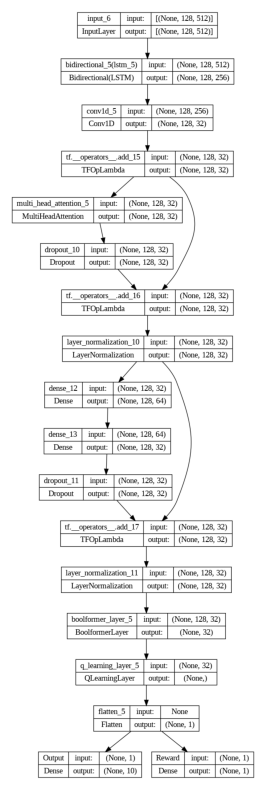

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 512)]           0         []                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 128, 256)             656384    ['input_6[0][0]']             
 onal)                                                                                            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 128, 32)              24608     ['bidirectional_5[0][0]']     
                                                                                                  
 tf.__operators__.add_15 (T  (None, 128, 32)              0         ['conv1d_5[0][0]']      

ValueError: cannot reshape array of size 333720 into shape (128,512)

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import dump
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Load and prepare the dataset
df = pd.read_csv('/content/synthetic_datasetV2.csv')
print("Dataset loaded.")

# Handling non-numeric data (if any)
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
if 'timestamp' in non_numeric_columns:
    df['timestamp'] = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9
    print("Timestamps converted to UNIX time.")

# Identify output and reward columns automatically
output_label_column = df.columns[-2]  # Output action labels
reward_label_column = df.columns[-1]  # Reward values

# Isolate the feature columns for input
input_columns = df.drop([output_label_column, reward_label_column], axis=1)

# Exclude 'text_data' column from feature standardization
input_columns = input_columns.drop('text_data', axis=1)  # Fix this line

# Standardize the feature columns
scaler = StandardScaler()
X = scaler.fit_transform(input_columns)
print("Features standardized.")

# Preparing output labels (encoding if categorical)
label_encoder = None
if df[output_label_column].dtype == 'object':
    label_encoder = LabelEncoder()
    Y_output = label_encoder.fit_transform(df[output_label_column])
    print("Output labels encoded.")
else:
    Y_output = df[output_label_column].values

# Prepare reward labels
Y_reward = df[reward_label_column].values

# Split the dataset into training and validation sets
X_train, X_val, Y_output_train, Y_output_val, Y_reward_train, Y_reward_val = train_test_split(
    X, Y_output, Y_reward, test_size=0.2, random_state=42
)
print("Data split into training and validation sets.")

# Configure callbacks for training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min'),
    keras.callbacks.ModelCheckpoint(filepath='/mnt/data/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Define BoolformerLayer and QLearningLayer classes
class BoolformerLayer(layers.Layer):
    def __init__(self, embedding_dim=8, num_heads=2, threshold_init_value=0.5, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.threshold_init_value = threshold_init_value

    def build(self, input_shape):
        self.threshold = self.add_weight(
            name='threshold',
            shape=(input_shape[-1],),
            initializer=tf.constant_initializer(self.threshold_init_value),
            trainable=True
        )
        self.embedding_layer = layers.Embedding(input_dim=2, output_dim=self.embedding_dim)
        self.attention_layer = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)
        self.attention_norm_layer = layers.LayerNormalization(epsilon=1e-6)
        self.dense_layer = layers.Dense(input_shape[-1], activation='relu')

    def call(self, inputs):
        boolean_inputs = tf.greater(inputs, self.threshold)
        embeddings = self.embedding_layer(tf.cast(boolean_inputs, dtype=tf.int32))
        attention_output = self.attention_layer(embeddings, embeddings)
        attention_output_norm = self.attention_norm_layer(attention_output)
        attention_output_flat = tf.reshape(attention_output_norm, shape=[-1, attention_output.shape[1] * self.embedding_dim])
        return self.dense_layer(attention_output_flat)

class QLearningLayer(layers.Layer):
    def __init__(self, action_space_size, state_size, learning_rate=0.01, gamma=0.95, epsilon=0.1, **kwargs):
        super().__init__(**kwargs)
        self.action_space_size = action_space_size
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def build(self, input_shape):
        self.q_network = layers.Dense(self.action_space_size)

    def call(self, state, action=None, reward=None, next_state=None):
        q_values = self.q_network(state)

        if action is not None and reward is not None and next_state is not None:
            next_state_q_values = self.q_network(next_state)
            target_q_value = reward + self.gamma * tf.reduce_max(next_state_q_values, axis=1)
            mask = tf.one_hot(action, self.action_space_size)

            with tf.GradientTape() as tape:
                current_q_values = self.q_network(state)
                q_action = tf.reduce_sum(tf.multiply(current_q_values, mask), axis=1)
                loss = tf.reduce_mean(tf.square(target_q_value - q_action))

            grads = tape.gradient(loss, self.q_network.trainable_variables)
            self.q_network.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

        action_probabilities = tf.nn.softmax(q_values, axis=1)
        chosen_action = tf.cond(
            tf.random.uniform([], 0, 1) < self.epsilon,
            lambda: tf.random.uniform([tf.shape(state)[0]], 0, self.action_space_size, dtype=tf.int64),
            lambda: tf.argmax(action_probabilities, axis=1)
        )
        return chosen_action

# Define positional_encoding, transformer_encoder, and create_neural_network_model functions
def positional_encoding(seq_length, d_model):
    position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model // 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    pos_encoding = position * div_term
    sin_cos_encoding = tf.concat([tf.sin(pos_encoding), tf.cos(pos_encoding)], axis=-1)
    return sin_cos_encoding[tf.newaxis, ...]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

def create_neural_network_model(seq_length, d_model, num_classes):
    input_layer = keras.Input(shape=(seq_length, d_model))

    pos_encoding = positional_encoding(seq_length, 32)

    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(input_layer)
    x_conv = layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x_lstm)

    x_pos_encoded = x_conv + pos_encoding

    transformer_output = transformer_encoder(x_pos_encoded, head_size=32, num_heads=2, ff_dim=64)

    state_size = transformer_output.shape[1] * transformer_output.shape[2]
    x_bool = BoolformerLayer()(transformer_output)
    rl_layer = QLearningLayer(action_space_size=num_classes, state_size=state_size)(x_bool)

    # Flatten the output from QLearningLayer before final dense layers
    reshaped_output = layers.Flatten()(rl_layer)

    output_layer = layers.Dense(num_classes, activation='softmax', name='Output')(reshaped_output)
    reward_layer = layers.Dense(1, name='Reward')(reshaped_output)

    model = keras.Model(inputs=input_layer, outputs=[output_layer, reward_layer])

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss={'Output': 'categorical_crossentropy', 'Reward': 'mean_squared_error'},
                  metrics={'Output': 'accuracy'})

    return model

seq_length = 128
d_model = 512
num_classes = 10

model = create_neural_network_model(seq_length, d_model, num_classes)

# Visualizing the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Displaying the model architecture image
image = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

# Printing the model summary
model.summary()

# Reshape the input data to match the model's expected shape
X_train_reshaped = X_train.reshape(-1, seq_length, d_model)
X_val_reshaped = X_val.reshape(-1, seq_length, d_model)

# Train the model with the corrected input shape
history = model.fit(
    X_train_reshaped,
    {'Output': keras.utils.to_categorical(Y_output_train, num_classes), 'Reward': Y_reward_train},
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, {'Output': keras.utils.to_categorical(Y_output_val, num_classes), 'Reward': Y_reward_val}),
    verbose=1,
    callbacks=callbacks
)

# Save the trained model
model.save('/mnt/data/SephsRL.h5')
print("Model saved.")

# Save the scaler and label encoder (if used)
scaler_filename = "/mnt/data/scaler.save"
dump(scaler, scaler_filename)
if label_encoder:
    label_encoder_filename = "/mnt/data/label_encoder.save"
    dump(label_encoder, label_encoder_filename)
print("Scaler and Label Encoder saved.")

# Visualization of the training process
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['Output_accuracy'])
plt.plot(history.history['val_Output_accuracy'])
plt.title('Model Output Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
print("Training process visualized.")


## Hyperparameter Settings

This section defines the hyperparameters for the model. Adjust these parameters to fine-tune the model's training process.


In [21]:

learning_rate = 0.001
batch_size = 32
epochs = 20
# Define additional hyperparameters here


## Model Training

In this section, we train the neural network model using the specified hyperparameters. The `model.fit()` function will be used to train the model with the training data. The validation data will be used to monitor the model's performance on unseen data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from joblib import dump
from tensorflow.keras.models import load_model

# Load and prepare the dataset
df = pd.read_csv('/content/synthetic_rl_dataset.csv')
print("Dataset loaded.")

# Handling non-numeric data (if any)
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
if 'timestamp' in non_numeric_columns:
    df['timestamp'] = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9
    print("Timestamps converted to UNIX time.")

# Identify output and reward columns automatically
output_label_column = df.columns[-2]  # Output action labels
reward_label_column = df.columns[-1]  # Reward values

# Isolate the feature columns for input
input_columns = df.drop([output_label_column, reward_label_column], axis=1)

# Standardize the feature columns
scaler = StandardScaler()
X = scaler.fit_transform(input_columns)
print("Features standardized.")

# Preparing output labels (encoding if categorical)
label_encoder = None
if df[output_label_column].dtype == 'object':
    label_encoder = LabelEncoder()
    Y_output = label_encoder.fit_transform(df[output_label_column])
    print("Output labels encoded.")
else:
    Y_output = df[output_label_column].values

# Prepare reward labels
Y_reward = df[reward_label_column].values

# Split the dataset into training and validation sets
X_train, X_val, Y_output_train, Y_output_val, Y_reward_train, Y_reward_val = train_test_split(
    X, Y_output, Y_reward, test_size=0.2, random_state=42
)
print("Data split into training and validation sets.")

# Load the model
model = load_model('/mnt/data/SephsRL.h5')

# Configure callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min'),
    ModelCheckpoint(filepath='/mnt/data/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with the corrected output layer names
history = model.fit(
    X_train,
    {'Output': Y_output_train, 'Reward': Y_reward_train},
    epochs=100,
    batch_size=32,
    validation_data=(X_val, {'Output': Y_output_val, 'Reward': Y_reward_val}),
    verbose=1,
    callbacks=callbacks
)
print("Model training complete.")

# Save the trained model
model.save('/mnt/data/SephsRL.h5')
print("Model saved.")

# Save the scaler and label encoder (if used)
scaler_filename = "/mnt/data/scaler.save"
dump(scaler, scaler_filename)
if label_encoder:
    label_encoder_filename = "/mnt/data/label_encoder.save"
    dump(label_encoder, label_encoder_filename)
print("Scaler and Label Encoder saved.")

## Model Evaluation

After training the model, it's important to evaluate its performance on a test dataset to understand its efficacy. The following code will use the `model.evaluate()` function to assess the model's accuracy and loss on the test data.

In [ ]:
# Evaluate the model on the test data
# test_data = ...

evaluation_metrics = model.evaluate(test_data)
print(f"Test Loss: {evaluation_metrics[0]}, Test Accuracy: {evaluation_metrics[1]}")


## Visualizing Model Performance

Functions for plotting and analyzing the model's performance during training.


In [ ]:

import matplotlib.pyplot as plt

# Function to plot training history for both 'Output' and 'Reward' outputs, tailored to their characteristics
def plot_custom_output_history(history):
    num_plots = 2 + ('accuracy' in history.history)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    plot_index = 0

    # Plotting accuracy for 'Output', if it's available
    if 'accuracy' in history.history:
        axes[plot_index].plot(history.history['accuracy'], label='Training Accuracy - Output')
        axes[plot_index].plot(history.history['val_accuracy'], label='Validation Accuracy - Output')
        axes[plot_index].set_title('Accuracy for Output')
        axes[plot_index].set_xlabel('Epochs')
        axes[plot_index].set_ylabel('Accuracy')
        axes[plot_index].legend()
        plot_index += 1

    # Plotting loss for 'Output'
    axes[plot_index].plot(history.history['Output_loss'], label='Training Loss - Output')
    axes[plot_index].plot(history.history['val_Output_loss'], label='Validation Loss - Output')
    axes[plot_index].set_title('Loss for Output')
    axes[plot_index].set_xlabel('Epochs')
    axes[plot_index].set_ylabel('Loss')
    axes[plot_index].legend()
    plot_index += 1

    # Plotting loss for 'Reward'
    axes[plot_index].plot(history.history['Reward_loss'], label='Training Loss - Reward')
    axes[plot_index].plot(history.history['val_Reward_loss'], label='Validation Loss - Reward')
    axes[plot_index].set_title('Loss for Reward')
    axes[plot_index].set_xlabel('Epochs')
    axes[plot_index].set_ylabel('Loss')
    axes[plot_index].legend()

    plt.tight_layout()
    plt.show()

# Call the function with the training history
plot_custom_output_history(history)



## Conclusion

This notebook provided a detailed walkthrough for developing, training, and evaluating a neural network model with custom layers and advanced techniques, ensuring good coding practices and clear documentation throughout.
